# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [5]:
# weather = pd.read_csv(path.joinpath('jena_climate_2009_2016.csv.zip'), 
#                       index_col='DateTime', 
#                       usecols=['DateTime','Temperature'], 
#                       parse_dates=True)

In [6]:
# daily_weather = weather.resample('D').mean()

In [7]:
# store the data set as a csv file
#daily_weather.to_csv(path.joinpath('daily_weather.csv'))

In [8]:
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)

In [9]:
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']

In [10]:
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

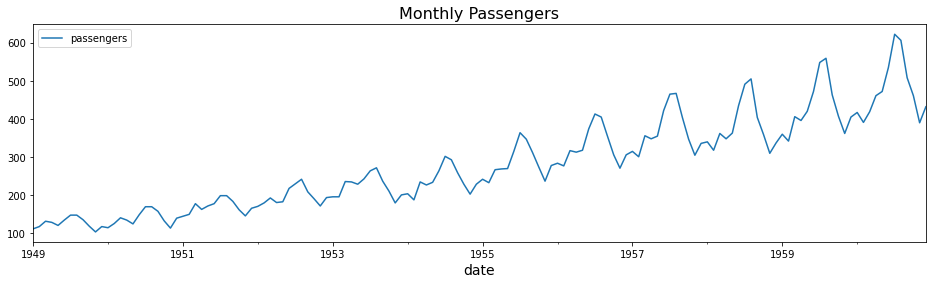

In [11]:
air.plot(title='Monthly Passengers')

<AxesSubplot:title={'center':'Avg Daily Weather Temperature in C'}, xlabel='DateTime'>

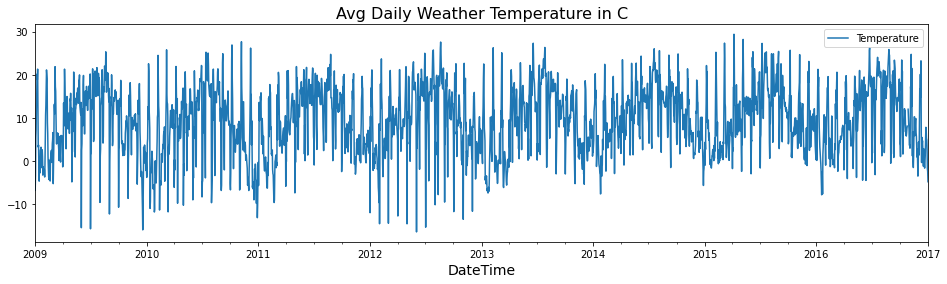

In [12]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')

<AxesSubplot:title={'center':'2012 Avg Daily Weather Temperature Pattern in C'}, xlabel='DateTime'>

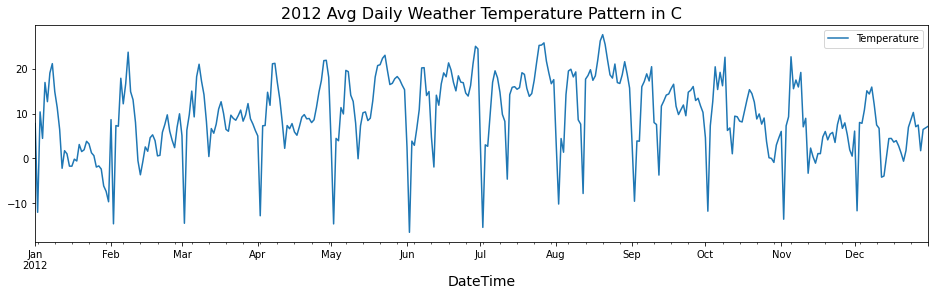

In [13]:
daily_weather.loc['2012'].plot(title='2012 Avg Daily Weather Temperature Pattern in C')

<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='Month'>

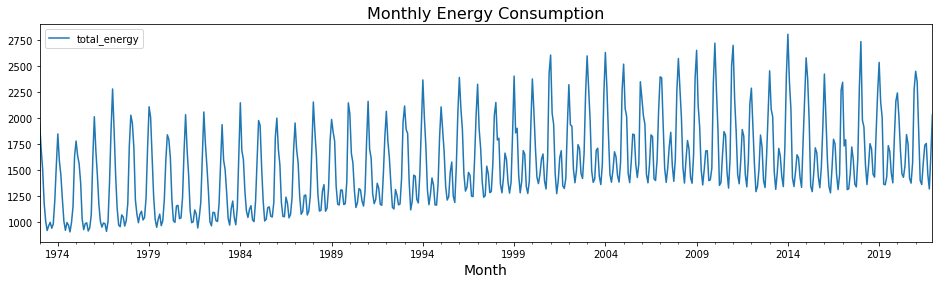

In [14]:
energy.plot(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'2012-2014 Monthly Energy Consumption Pattern'}, xlabel='Month'>

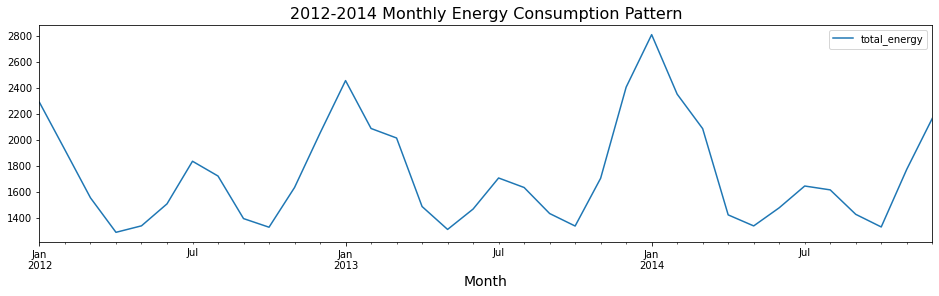

In [15]:
energy.loc['2012':'2014'].plot(title='2012-2014 Monthly Energy Consumption Pattern')

In [16]:
energy.isna().sum()

total_energy    0
dtype: int64

In [17]:
daily_weather.ffill(inplace=True)

In [18]:
daily_weather.isna().sum()

Temperature    0
dtype: int64

In [19]:
air.isna().sum()

passengers    0
dtype: int64

## Tranform the data sets
### Windowing

In [20]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [21]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

In [22]:
air_d.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [23]:
dw_d.head()

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847


In [24]:
en_d.head()

,x_1,x_2,x_3,x_4,x_5,y
Month,,,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949
1973-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872
1973-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259
1973-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083
1973-05-01,1006.326,914.949,961.872,994.259,937.083,978.162


### Scale and split data

In [25]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [26]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [27]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



In [28]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.418086,-1.335433,-1.163321,-1.213649,-1.331677,-1.193676
1949-02-28,-1.340522,-1.160959,-1.199458,-1.308609,-1.165784,-1.038787
1949-03-31,-1.159538,-1.198346,-1.295820,-1.142429,-1.011740,-1.038787
1949-04-30,-1.198320,-1.298045,-1.127185,-0.988119,-1.011740,-1.181762
1949-05-31,-1.301740,-1.123572,-0.970596,-0.988119,-1.153934,-1.384309


In [29]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


### Split into X and Y (Features and Target)

In [30]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [31]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

In [32]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

In [33]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [34]:
scale_air.inverse_y(y_train_air)[0:5]

array([[135.],
       [148.],
       [148.],
       [136.],
       [119.]])

In [35]:
x_train_air.shape

(102, 5, 1)

In [284]:
type(x_train_air)

numpy.ndarray

In [36]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(102, 1) (20, 1) (17, 1)


## There is more

In [37]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [38]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [39]:
# scale = StandardScaler()
# scale.fit(train)

In [40]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [41]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

# Forecasting with Keras

In [42]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [43]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [44]:
def train_model(model, 
                x_train, 
                y_train, 
                x_val, 
                y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       min_delta=0, 
                                       patience=patience)
    
    history = model.fit(x_train,
              y_train, 
              shuffle=False, 
              epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es],
              verbose=1)
    return history

In [45]:
def plot_forecast(model, x_test, y_test, index, history):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    pd.Series(history.history['root_mean_squared_error']).plot(style='k',
                                                               alpha=0.50,
                                                               ax=ax1, 
                                                               title='RMSE by EPOCH',
                                                              label='rmse')
    pd.Series(history.history['val_root_mean_squared_error']).plot(style='k',
                                                                   ax=ax1,
                                                                  label='val_rmse')
    plt.legend()

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    pd.Series(history.history['mean_absolute_error']).plot(style='k',
                                                           alpha=0.50,
                                                           ax=ax2,
                                                          title='MAE by EPOCH',
                                                          label='mae')
    pd.Series(history.history['val_mean_absolute_error']).plot(style='k',
                                                               ax=ax2,
                                                              label='val_mae')
    plt.legend()
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax3, 
                                title='Forecast vs Actual',
                               label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax3)
    plt.legend();plt.show()


### Air Passenger

In [46]:
tf.keras.backend.clear_session()

In [47]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

2022-04-24 07:24:10.792390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_a_simpleRNN = train_model(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 1s 65ms/step - loss: 1.8683 - root_mean_squared_error: 1.3669 - mean_absolute_error: 1.1339 - val_loss: 4.4976 - val_root_mean_squared_error: 2.1208 - val_mean_absolute_error: 1.9679
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 1.1938 - root_mean_squared_error: 1.0926 - mean_absolute_error: 0.8838 - val_loss: 3.3093 - val_root_mean_squared_error: 1.8192 - val_mean_absolute_error: 1.6243
Epoch 3/500
4/4 [==============================] - 0s 8ms/step - loss: 0.8988 - root_mean_squared_error: 0.9481 - mean_absolute_error: 0.7654 - val_loss: 2.3918 - val_root_mean_squared_error: 1.5465 - val_mean_absolute_error: 1.2974
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 0.6144 - root_mean_squared_error: 0.7839 - mean_absolute_error: 0.6208 - val_loss: 1.7255 - val_root_mean_squared_error: 1.3136 - val_mean_absolute_error: 0.9963
Epoch 5/500
4/4 [==============================] - 0s 8ms/step - lo

In [50]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [51]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 19ms/step - loss: 1.3571 - root_mean_squared_error: 1.1650 - mean_absolute_error: 0.9687


[1.357119083404541, 1.1649545431137085, 0.9686874151229858]

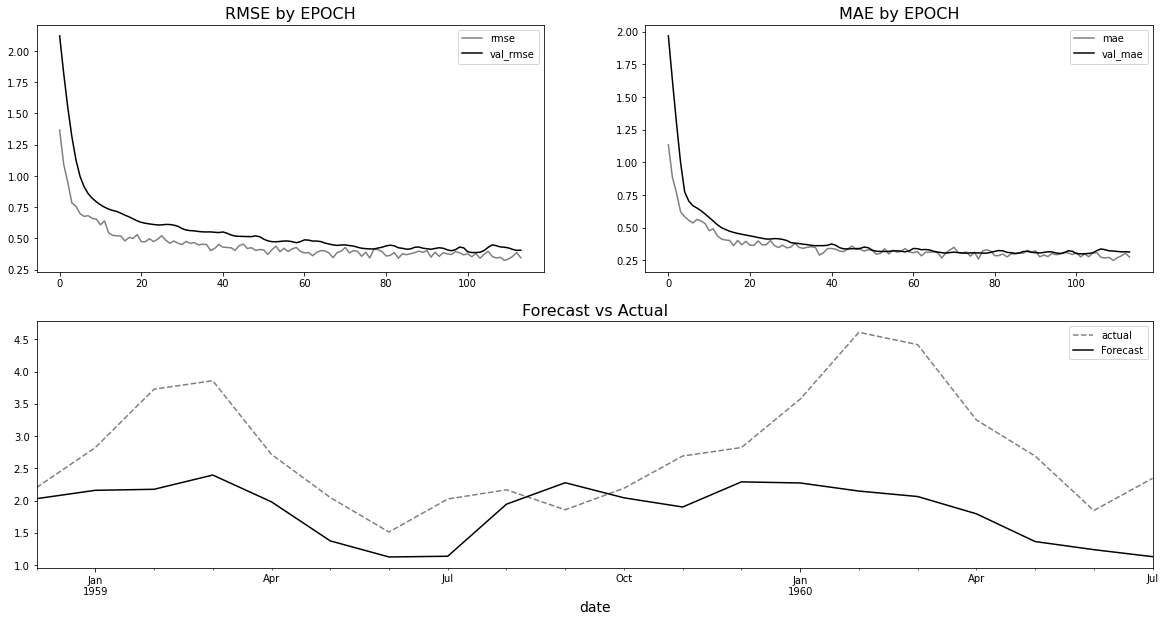

In [52]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [53]:
tf.keras.backend.clear_session()

In [54]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [55]:
model_dw_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [56]:
history_dw_simpleRNN = train_model(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
33/33 [==============================] - 1s 8ms/step - loss: 0.6469 - root_mean_squared_error: 0.8043 - mean_absolute_error: 0.6021 - val_loss: 0.3859 - val_root_mean_squared_error: 0.6212 - val_mean_absolute_error: 0.4758
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.5159 - root_mean_squared_error: 0.7183 - mean_absolute_error: 0.5327 - val_loss: 0.3442 - val_root_mean_squared_error: 0.5867 - val_mean_absolute_error: 0.4486
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.4665 - root_mean_squared_error: 0.6830 - mean_absolute_error: 0.4907 - val_loss: 0.3247 - val_root_mean_squared_error: 0.5698 - val_mean_absolute_error: 0.4263
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.4427 - root_mean_squared_error: 0.6654 - mean_absolute_error: 0.4776 - val_loss: 0.3162 - val_root_mean_squared_error: 0.5623 - val_mean_absolute_error: 0.4150
Epoch 5/500
33/33 [==============================] - 0s 3ms/

In [57]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

14/14 [==============================] - 0s 2ms/step - loss: 0.3532 - root_mean_squared_error: 0.5943 - mean_absolute_error: 0.4480


[0.3531620502471924, 0.5942744016647339, 0.44801822304725647]

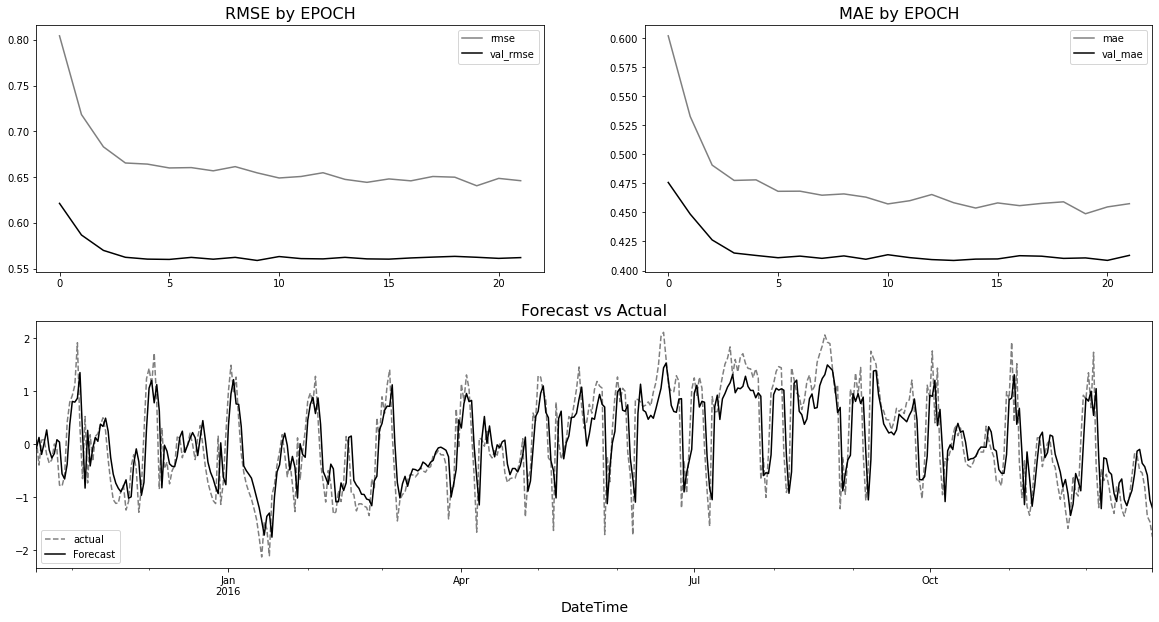

In [58]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [59]:
tf.keras.backend.clear_session()

In [60]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [61]:
history_en_simpleRNN = train_model(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
7/7 [==============================] - 1s 32ms/step - loss: 0.8793 - root_mean_squared_error: 0.9377 - mean_absolute_error: 0.7528 - val_loss: 1.2402 - val_root_mean_squared_error: 1.1137 - val_mean_absolute_error: 0.8149
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 0.6708 - root_mean_squared_error: 0.8190 - mean_absolute_error: 0.6602 - val_loss: 1.0661 - val_root_mean_squared_error: 1.0325 - val_mean_absolute_error: 0.7662
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 0.6446 - root_mean_squared_error: 0.8029 - mean_absolute_error: 0.6413 - val_loss: 0.9356 - val_root_mean_squared_error: 0.9673 - val_mean_absolute_error: 0.7082
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.5603 - root_mean_squared_error: 0.7485 - mean_absolute_error: 0.6065 - val_loss: 0.8295 - val_root_mean_squared_error: 0.9108 - val_mean_absolute_error: 0.6584
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - lo

In [62]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

3/3 [==============================] - 0s 2ms/step - loss: 0.2554 - root_mean_squared_error: 0.5053 - mean_absolute_error: 0.3870


[0.2553595304489136, 0.5053310990333557, 0.38696375489234924]

In [63]:
y_test_air.shape

(20, 1)

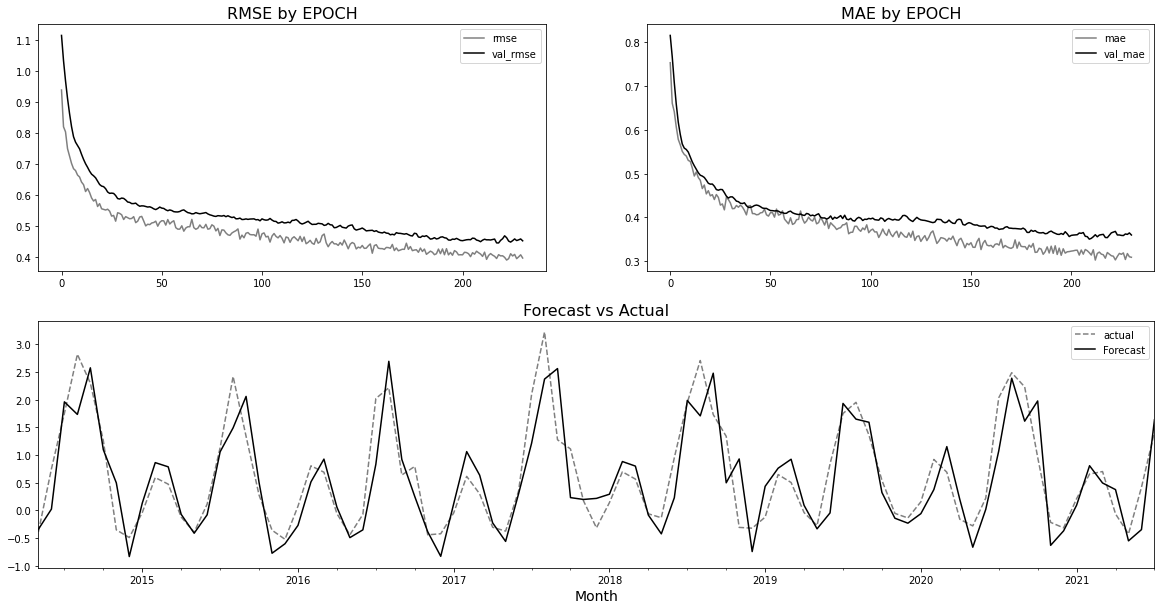

In [64]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [65]:
scale_en.inverse_y(y_test_en[0:5])

array([[1331.478],
       [1773.932],
       [2164.807],
       [2580.929],
       [2377.381]])

In [66]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

array([[1349.3652],
       [1490.657 ],
       [2245.8904],
       [2157.3591],
       [2485.452 ]], dtype=float32)

## LSTM

In [67]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [68]:
tf.keras.backend.clear_session()

In [69]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [70]:
history_a_lstm = train_model(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 2s 149ms/step - loss: 1.0181 - root_mean_squared_error: 1.0090 - mean_absolute_error: 0.8276 - val_loss: 3.0487 - val_root_mean_squared_error: 1.7460 - val_mean_absolute_error: 1.6261
Epoch 2/500
4/4 [==============================] - 0s 11ms/step - loss: 0.9312 - root_mean_squared_error: 0.9650 - mean_absolute_error: 0.7911 - val_loss: 2.7921 - val_root_mean_squared_error: 1.6710 - val_mean_absolute_error: 1.5439
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 0.8493 - root_mean_squared_error: 0.9216 - mean_absolute_error: 0.7528 - val_loss: 2.5376 - val_root_mean_squared_error: 1.5930 - val_mean_absolute_error: 1.4575
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 0.7887 - root_mean_squared_error: 0.8881 - mean_absolute_error: 0.7195 - val_loss: 2.2872 - val_root_mean_squared_error: 1.5124 - val_mean_absolute_error: 1.3668
Epoch 5/500
4/4 [==============================] - 0s 12ms/step

In [71]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 17ms/step - loss: 0.7678 - root_mean_squared_error: 0.8762 - mean_absolute_error: 0.7078


[0.7677901387214661, 0.8762363195419312, 0.7077915072441101]

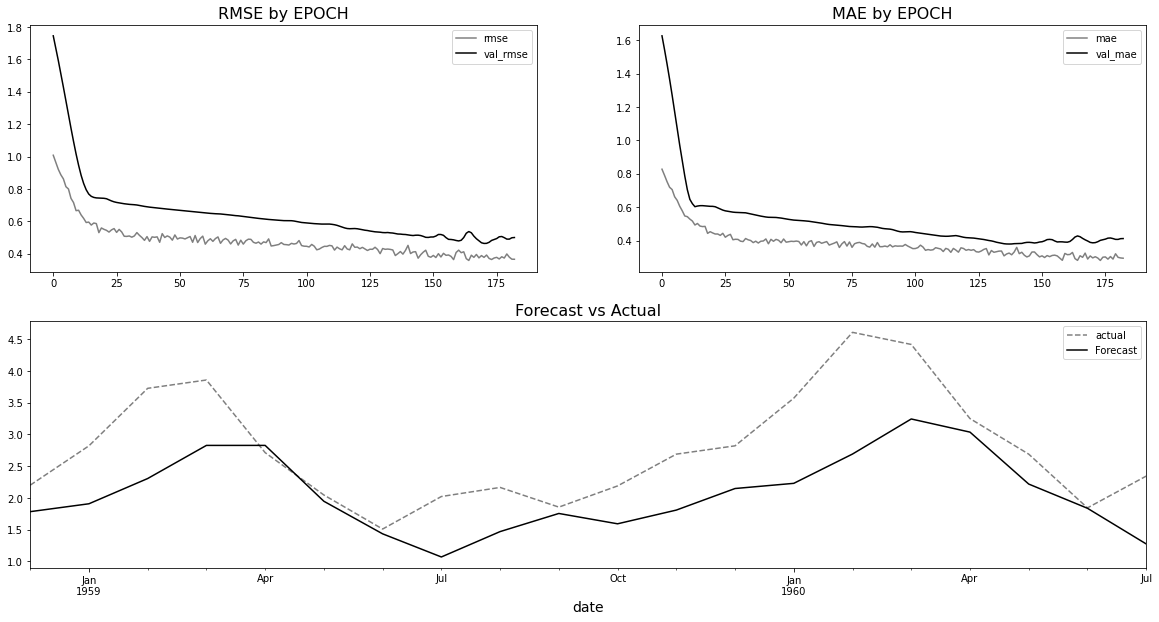

In [72]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [73]:
tf.keras.backend.clear_session()

In [74]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_dw_lstm = train_model(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
33/33 [==============================] - 2s 18ms/step - loss: 1.0128 - root_mean_squared_error: 1.0064 - mean_absolute_error: 0.8316 - val_loss: 0.6822 - val_root_mean_squared_error: 0.8260 - val_mean_absolute_error: 0.6643
Epoch 2/500
33/33 [==============================] - 0s 5ms/step - loss: 0.8025 - root_mean_squared_error: 0.8958 - mean_absolute_error: 0.7182 - val_loss: 0.5829 - val_root_mean_squared_error: 0.7635 - val_mean_absolute_error: 0.5825
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.7254 - root_mean_squared_error: 0.8517 - mean_absolute_error: 0.6662 - val_loss: 0.5337 - val_root_mean_squared_error: 0.7305 - val_mean_absolute_error: 0.5528
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.6647 - root_mean_squared_error: 0.8153 - mean_absolute_error: 0.6312 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6997 - val_mean_absolute_error: 0.5301
Epoch 5/500
33/33 [==============================] - 0s 4ms

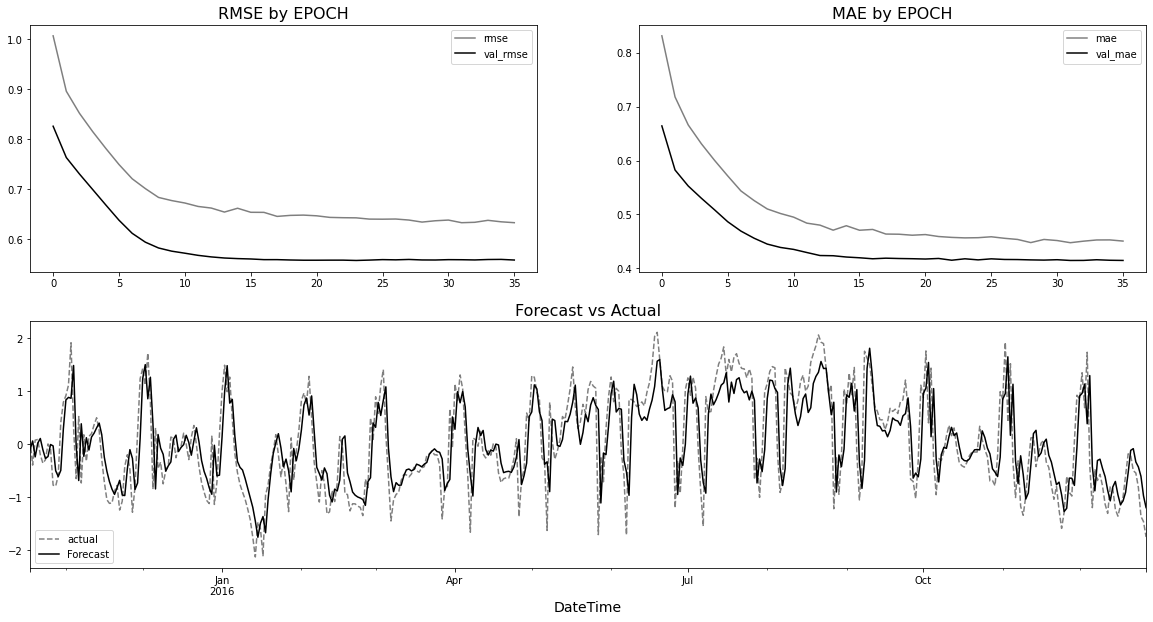

In [76]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [77]:
tf.keras.backend.clear_session()

In [78]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [79]:
history_en_lstm = train_model(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
7/7 [==============================] - 2s 69ms/step - loss: 1.0360 - root_mean_squared_error: 1.0178 - mean_absolute_error: 0.8331 - val_loss: 1.5951 - val_root_mean_squared_error: 1.2630 - val_mean_absolute_error: 0.8814
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 0.9918 - root_mean_squared_error: 0.9959 - mean_absolute_error: 0.8166 - val_loss: 1.5357 - val_root_mean_squared_error: 1.2392 - val_mean_absolute_error: 0.8688
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 0.9548 - root_mean_squared_error: 0.9771 - mean_absolute_error: 0.8033 - val_loss: 1.4781 - val_root_mean_squared_error: 1.2158 - val_mean_absolute_error: 0.8594
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 0.9317 - root_mean_squared_error: 0.9653 - mean_absolute_error: 0.7957 - val_loss: 1.4266 - val_root_mean_squared_error: 1.1944 - val_mean_absolute_error: 0.8509
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - lo

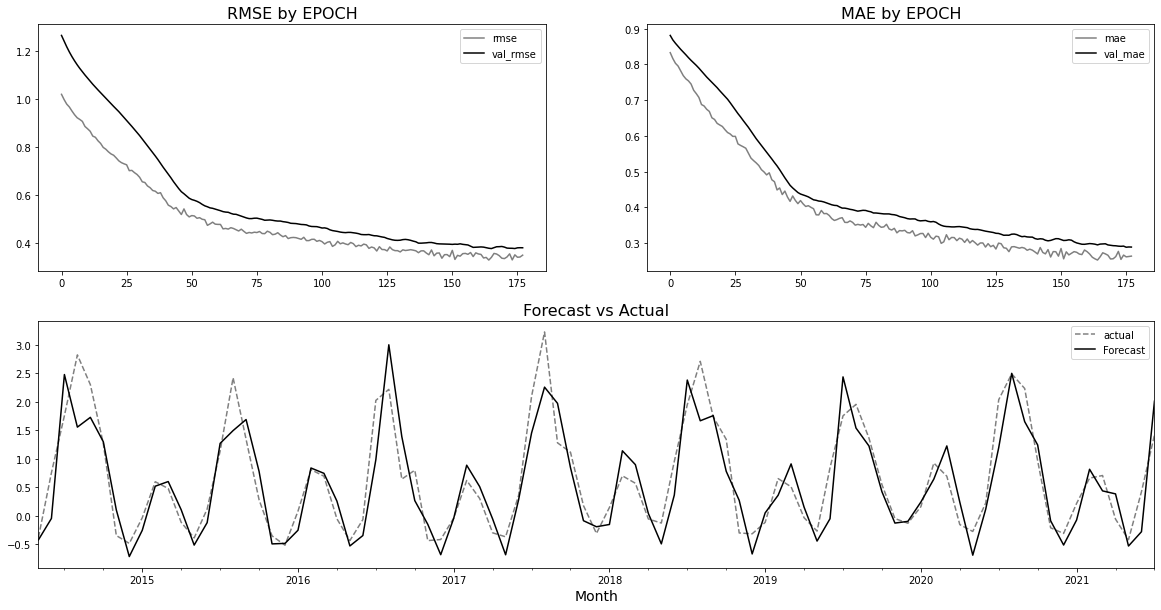

In [80]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [81]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [82]:
tf.keras.backend.clear_session()

In [83]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/500
4/4 [==============================] - 2s 138ms/step - loss: 0.3810 - root_mean_squared_error: 0.6173 - mean_absolute_error: 0.4877 - val_loss: 1.0042 - val_root_mean_squared_error: 1.0021 - val_mean_absolute_error: 0.8254
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2840 - root_mean_squared_error: 0.5329 - mean_absolute_error: 0.4204 - val_loss: 0.8118 - val_root_mean_squared_error: 0.9010 - val_mean_absolute_error: 0.7101
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.2536 - root_mean_squared_error: 0.5036 - mean_absolute_error: 0.3995 - val_loss: 0.6570 - val_root_mean_squared_error: 0.8106 - val_mean_absolute_error: 0.6128
Epoch 4/500
4/4 [==============================] - 0s 14ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821 - mean_absolute_error: 0.3756 - val_loss: 0.5428 - val_root_mean_squared_error: 0.7367 - val_mean_absolute_error: 0.5438
Epoch 5/500
4/4 [==============================] - 0s 12ms/step

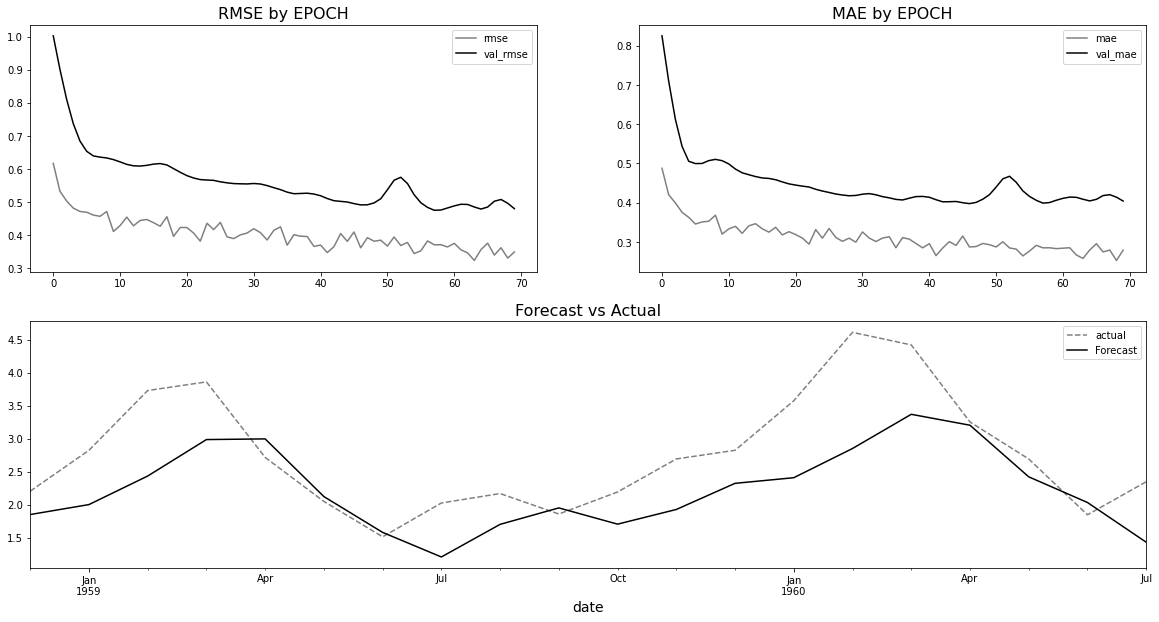

In [84]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [85]:
tf.keras.backend.clear_session()

In [86]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
33/33 [==============================] - 3s 21ms/step - loss: 0.7312 - root_mean_squared_error: 0.8551 - mean_absolute_error: 0.6878 - val_loss: 0.4698 - val_root_mean_squared_error: 0.6854 - val_mean_absolute_error: 0.5195
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.5878 - root_mean_squared_error: 0.7667 - mean_absolute_error: 0.5810 - val_loss: 0.4093 - val_root_mean_squared_error: 0.6398 - val_mean_absolute_error: 0.4747
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.5291 - root_mean_squared_error: 0.7274 - mean_absolute_error: 0.5421 - val_loss: 0.3703 - val_root_mean_squared_error: 0.6085 - val_mean_absolute_error: 0.4525
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.4934 - root_mean_squared_error: 0.7024 - mean_absolute_error: 0.5165 - val_loss: 0.3417 - val_root_mean_squared_error: 0.5845 - val_mean_absolute_error: 0.4347
Epoch 5/500
33/33 [==============================] - 0s 5ms

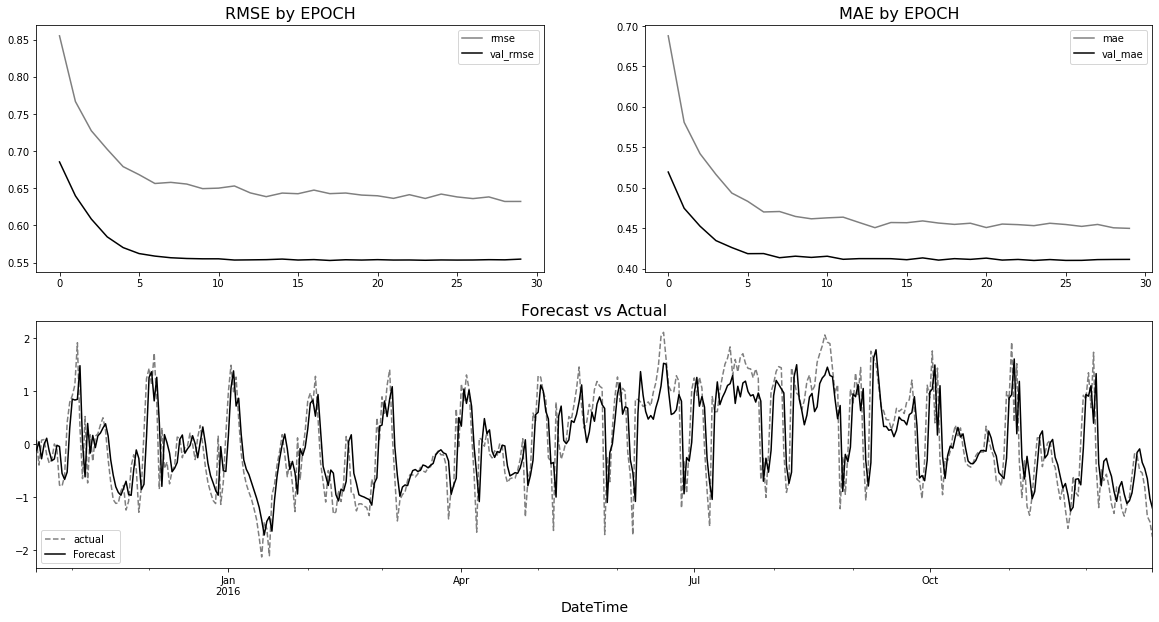

In [87]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [88]:
tf.keras.backend.clear_session()

In [89]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [90]:
history_en_gru = train_model(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
7/7 [==============================] - 2s 70ms/step - loss: 1.2079 - root_mean_squared_error: 1.0990 - mean_absolute_error: 0.9003 - val_loss: 1.8358 - val_root_mean_squared_error: 1.3549 - val_mean_absolute_error: 0.9405
Epoch 2/500
7/7 [==============================] - 0s 8ms/step - loss: 1.1150 - root_mean_squared_error: 1.0559 - mean_absolute_error: 0.8677 - val_loss: 1.7071 - val_root_mean_squared_error: 1.3066 - val_mean_absolute_error: 0.9102
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 1.0495 - root_mean_squared_error: 1.0245 - mean_absolute_error: 0.8458 - val_loss: 1.5905 - val_root_mean_squared_error: 1.2612 - val_mean_absolute_error: 0.8881
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.9978 - root_mean_squared_error: 0.9989 - mean_absolute_error: 0.8231 - val_loss: 1.4891 - val_root_mean_squared_error: 1.2203 - val_mean_absolute_error: 0.8723
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - l

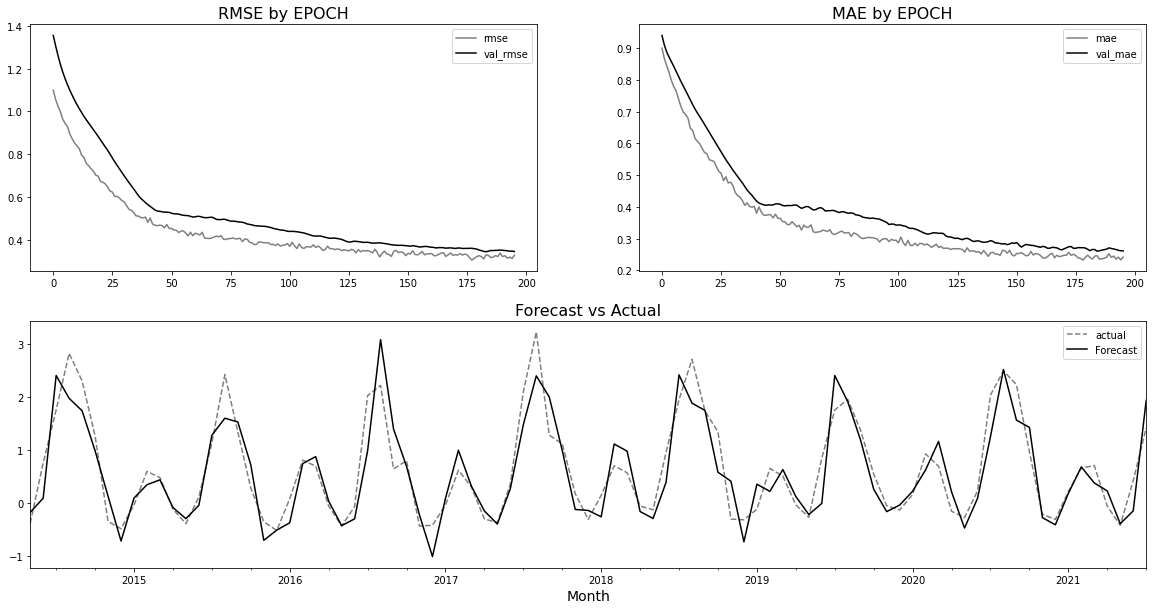

In [91]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [92]:
tf.keras.backend.clear_session()

In [93]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [94]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 4s 248ms/step - loss: 1.0165 - root_mean_squared_error: 1.0082 - mean_absolute_error: 0.8203 - val_loss: 3.2072 - val_root_mean_squared_error: 1.7909 - val_mean_absolute_error: 1.6692
Epoch 2/500
4/4 [==============================] - 0s 15ms/step - loss: 0.9149 - root_mean_squared_error: 0.9565 - mean_absolute_error: 0.7755 - val_loss: 2.9016 - val_root_mean_squared_error: 1.7034 - val_mean_absolute_error: 1.5728
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 0.8451 - root_mean_squared_error: 0.9193 - mean_absolute_error: 0.7439 - val_loss: 2.5968 - val_root_mean_squared_error: 1.6114 - val_mean_absolute_error: 1.4699
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 0.7690 - root_mean_squared_error: 0.8769 - mean_absolute_error: 0.7109 - val_loss: 2.2924 - val_root_mean_squared_error: 1.5141 - val_mean_absolute_error: 1.3586
Epoch 5/500
4/4 [==============================] - 0s 16ms/step

In [95]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 24ms/step - loss: 1.3550 - root_mean_squared_error: 1.1640 - mean_absolute_error: 1.0327


[1.3549697399139404, 1.1640316247940063, 1.0326591730117798]

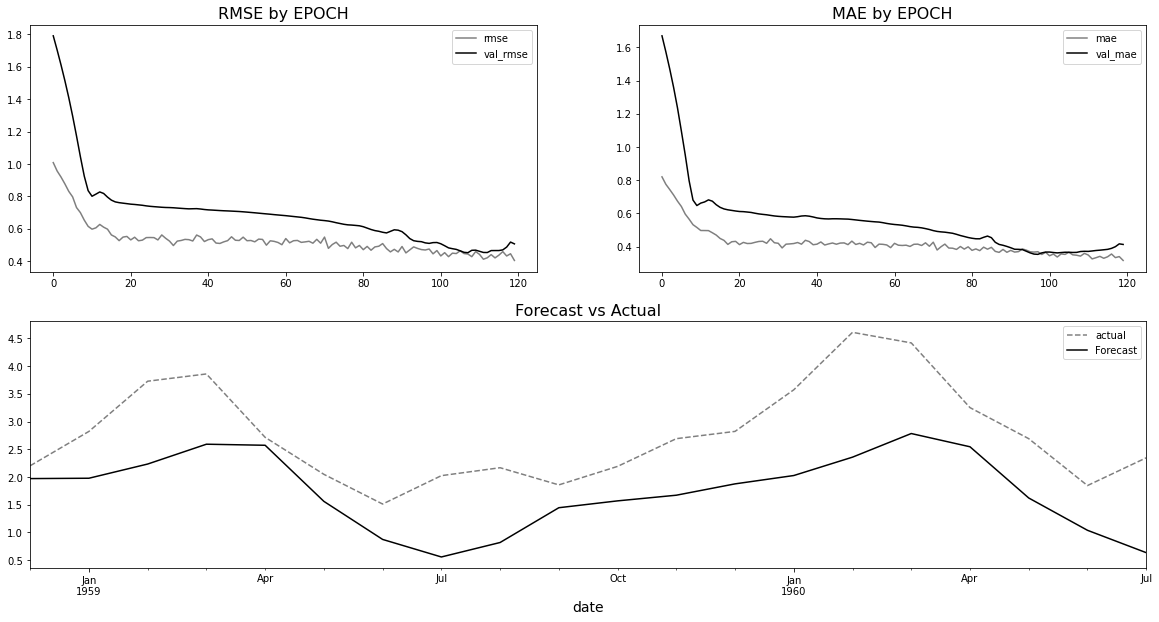

In [96]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

In [97]:
tf.keras.backend.clear_session()

Epoch 1/500
33/33 [==============================] - 4s 31ms/step - loss: 0.8428 - root_mean_squared_error: 0.9180 - mean_absolute_error: 0.7454 - val_loss: 0.6211 - val_root_mean_squared_error: 0.7881 - val_mean_absolute_error: 0.5972
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.7598 - root_mean_squared_error: 0.8717 - mean_absolute_error: 0.6857 - val_loss: 0.5740 - val_root_mean_squared_error: 0.7576 - val_mean_absolute_error: 0.5773
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.7051 - root_mean_squared_error: 0.8397 - mean_absolute_error: 0.6553 - val_loss: 0.5202 - val_root_mean_squared_error: 0.7212 - val_mean_absolute_error: 0.5505
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.6323 - root_mean_squared_error: 0.7951 - mean_absolute_error: 0.6160 - val_loss: 0.4482 - val_root_mean_squared_error: 0.6695 - val_mean_absolute_error: 0.5102
Epoch 5/500
33/33 [==============================] - 0s 7ms

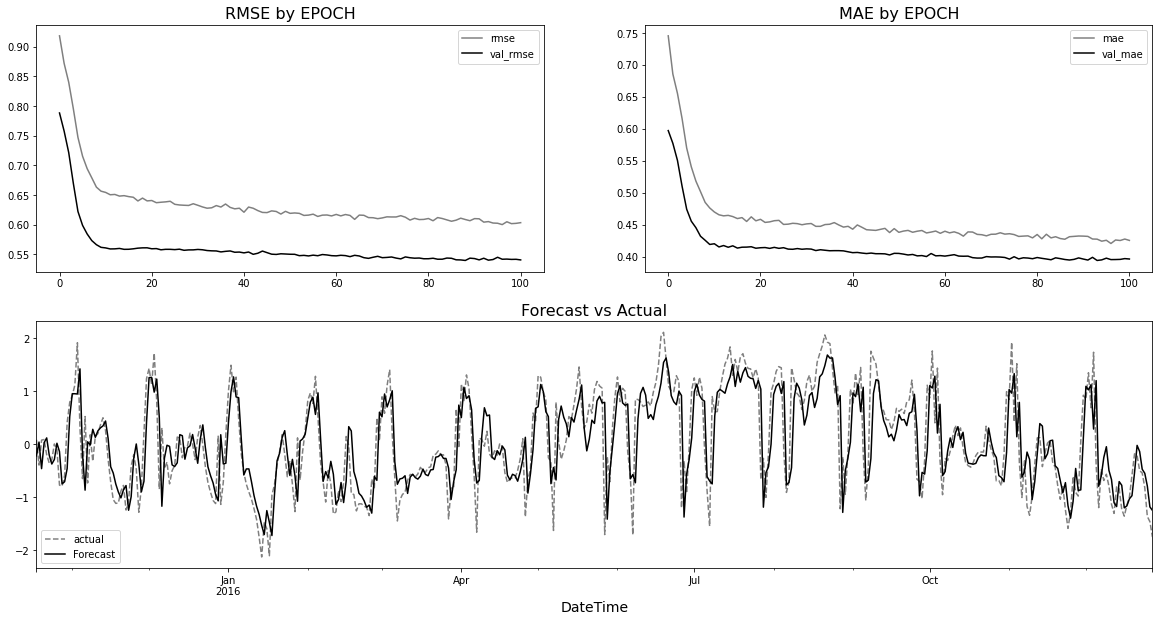

In [98]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

In [99]:
tf.keras.backend.clear_session()

Epoch 1/500
7/7 [==============================] - 4s 129ms/step - loss: 1.0064 - root_mean_squared_error: 1.0032 - mean_absolute_error: 0.8205 - val_loss: 1.5920 - val_root_mean_squared_error: 1.2618 - val_mean_absolute_error: 0.8805
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.9781 - root_mean_squared_error: 0.9890 - mean_absolute_error: 0.8102 - val_loss: 1.5481 - val_root_mean_squared_error: 1.2442 - val_mean_absolute_error: 0.8709
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 0.9624 - root_mean_squared_error: 0.9810 - mean_absolute_error: 0.8051 - val_loss: 1.5062 - val_root_mean_squared_error: 1.2273 - val_mean_absolute_error: 0.8654
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 0.9512 - root_mean_squared_error: 0.9753 - mean_absolute_error: 0.8030 - val_loss: 1.4690 - val_root_mean_squared_error: 1.2120 - val_mean_absolute_error: 0.8606
Epoch 5/500
7/7 [==============================] - 0s 8ms/step -

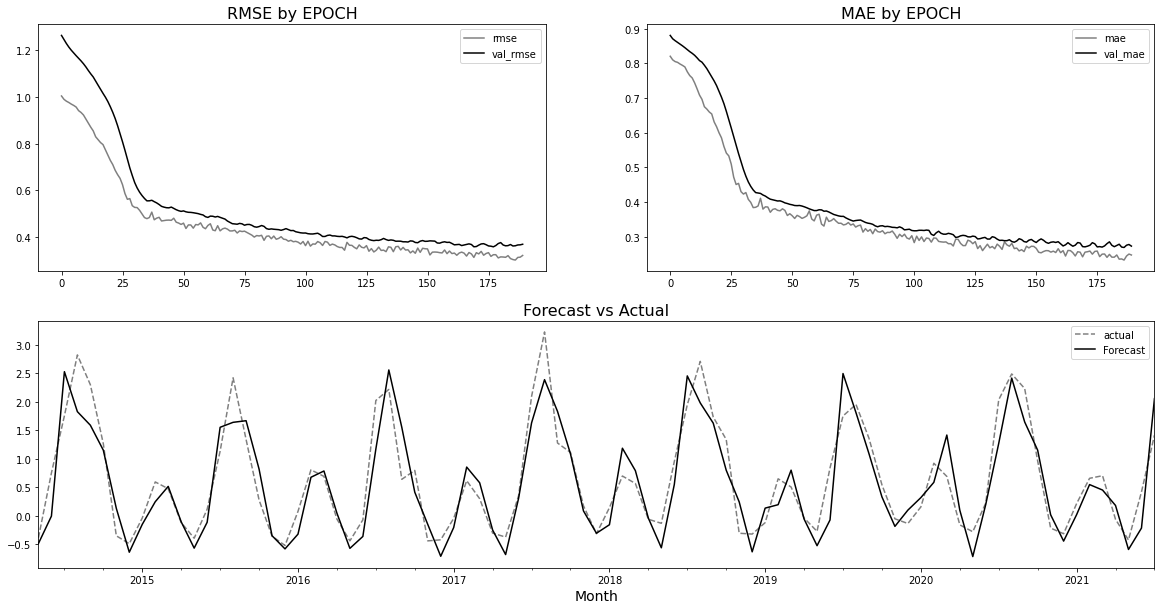

In [100]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [101]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [102]:
tf.keras.backend.clear_session()

In [103]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 7s 398ms/step - loss: 0.9254 - root_mean_squared_error: 0.9620 - mean_absolute_error: 0.7837 - val_loss: 2.6336 - val_root_mean_squared_error: 1.6228 - val_mean_absolute_error: 1.4888
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.6963 - root_mean_squared_error: 0.8345 - mean_absolute_error: 0.6737 - val_loss: 1.9825 - val_root_mean_squared_error: 1.4080 - val_mean_absolute_error: 1.2478
Epoch 3/500
4/4 [==============================] - 0s 13ms/step - loss: 0.5394 - root_mean_squared_error: 0.7345 - mean_absolute_error: 0.5867 - val_loss: 1.4191 - val_root_mean_squared_error: 1.1912 - val_mean_absolute_error: 0.9914
Epoch 4/500
4/4 [==============================] - 0s 13ms/step - loss: 0.4012 - root_mean_squared_error: 0.6334 - mean_absolute_error: 0.5075 - val_loss: 0.9620 - val_root_mean_squared_error: 0.9808 - val_mean_absolute_error: 0.7553
Epoch 5/500
4/4 [==============================] - 0s 13ms/step

In [104]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 18ms/step - loss: 2.2043 - root_mean_squared_error: 1.4847 - mean_absolute_error: 1.3375


[2.2042975425720215, 1.4846876859664917, 1.337501883506775]

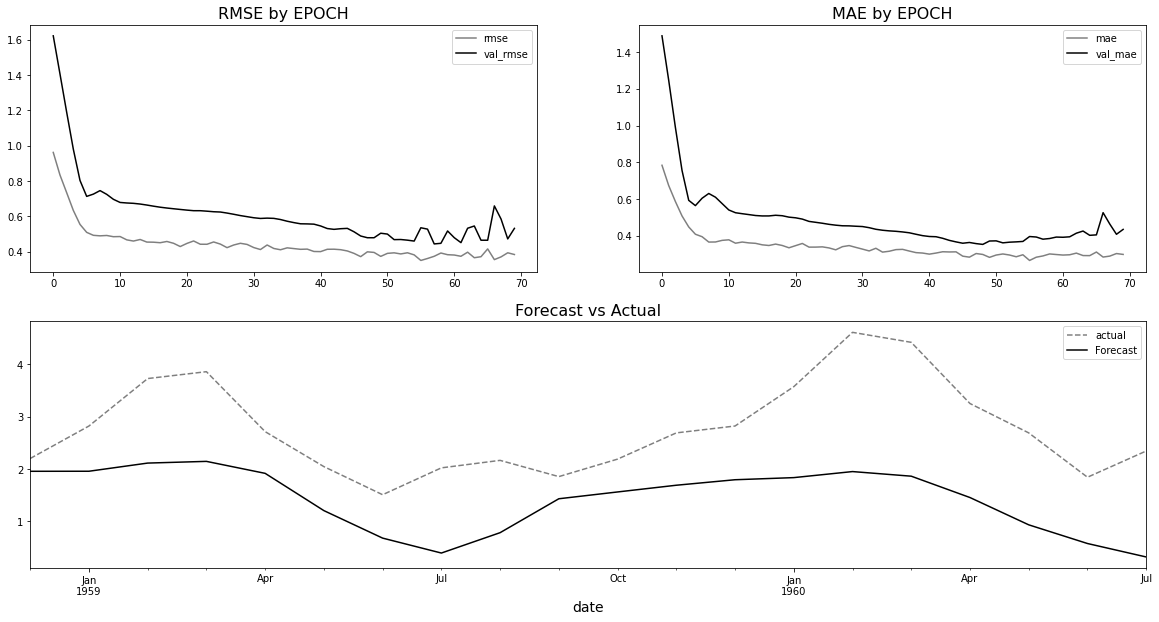

In [105]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [106]:
tf.keras.backend.clear_session()

In [107]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
33/33 [==============================] - 7s 44ms/step - loss: 0.7458 - root_mean_squared_error: 0.8636 - mean_absolute_error: 0.6825 - val_loss: 0.4834 - val_root_mean_squared_error: 0.6953 - val_mean_absolute_error: 0.5068
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.5760 - root_mean_squared_error: 0.7590 - mean_absolute_error: 0.5651 - val_loss: 0.3754 - val_root_mean_squared_error: 0.6127 - val_mean_absolute_error: 0.4547
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.4908 - root_mean_squared_error: 0.7006 - mean_absolute_error: 0.5137 - val_loss: 0.3348 - val_root_mean_squared_error: 0.5786 - val_mean_absolute_error: 0.4338
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.4799 - root_mean_squared_error: 0.6927 - mean_absolute_error: 0.5091 - val_loss: 0.3271 - val_root_mean_squared_error: 0.5719 - val_mean_absolute_error: 0.4295
Epoch 5/500
33/33 [==============================] - 0s 7ms

In [108]:
x_test_dw.shape

(437, 5, 1)

In [109]:
model_dw_bd.predict(x_test_dw).shape

(437, 1)

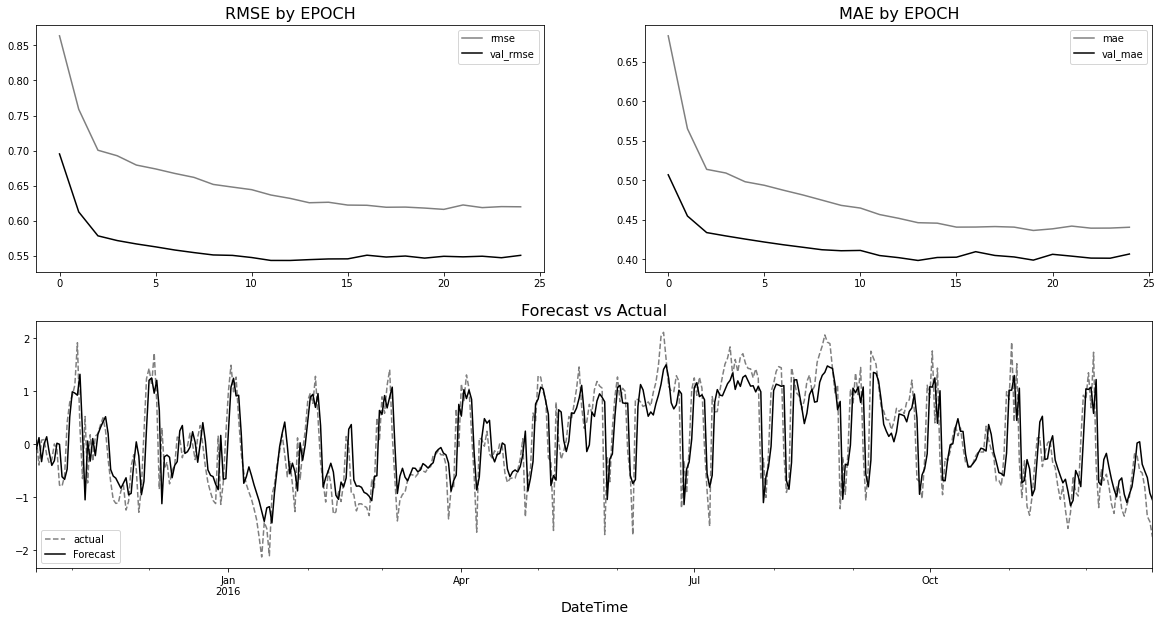

In [110]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

In [111]:
tf.keras.backend.clear_session()

Epoch 1/500
7/7 [==============================] - 7s 226ms/step - loss: 0.9704 - root_mean_squared_error: 0.9851 - mean_absolute_error: 0.8124 - val_loss: 1.4555 - val_root_mean_squared_error: 1.2064 - val_mean_absolute_error: 0.8631
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 0.9095 - root_mean_squared_error: 0.9537 - mean_absolute_error: 0.7854 - val_loss: 1.3675 - val_root_mean_squared_error: 1.1694 - val_mean_absolute_error: 0.8523
Epoch 3/500
7/7 [==============================] - 0s 12ms/step - loss: 0.8587 - root_mean_squared_error: 0.9267 - mean_absolute_error: 0.7617 - val_loss: 1.2808 - val_root_mean_squared_error: 1.1317 - val_mean_absolute_error: 0.8383
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.8150 - root_mean_squared_error: 0.9028 - mean_absolute_error: 0.7372 - val_loss: 1.1977 - val_root_mean_squared_error: 1.0944 - val_mean_absolute_error: 0.8194
Epoch 5/500
7/7 [==============================] - 0s 12ms/step

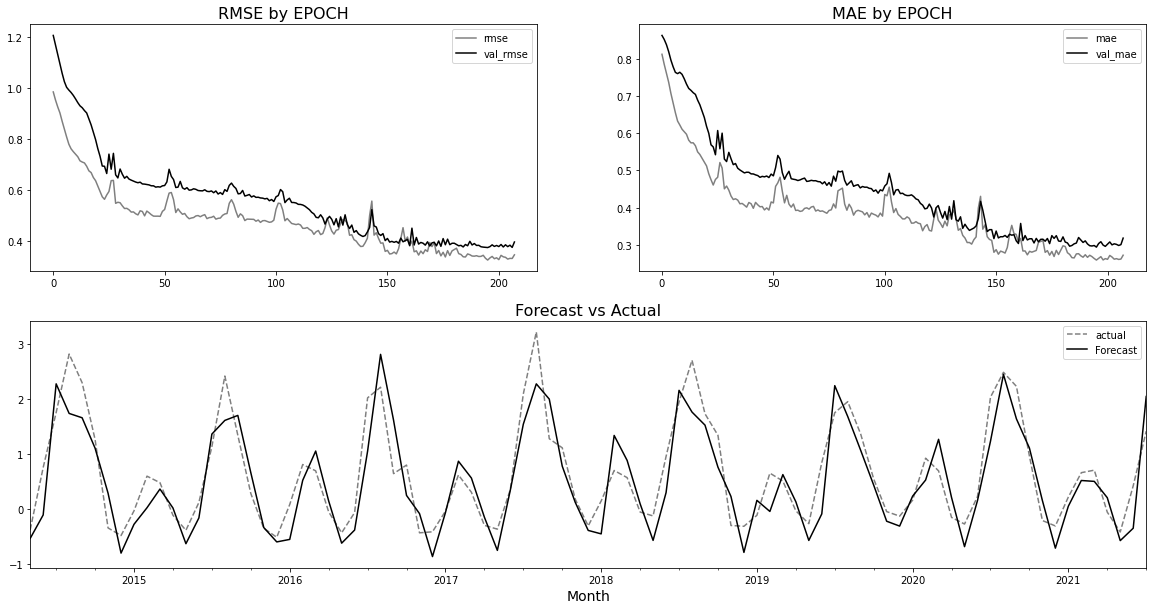

In [112]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [113]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [114]:
tf.keras.backend.clear_session()

In [115]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 3s 226ms/step - loss: 1.0183 - root_mean_squared_error: 1.0091 - mean_absolute_error: 0.8219 - val_loss: 3.2581 - val_root_mean_squared_error: 1.8050 - val_mean_absolute_error: 1.6831
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.9724 - root_mean_squared_error: 0.9861 - mean_absolute_error: 0.8015 - val_loss: 3.1087 - val_root_mean_squared_error: 1.7632 - val_mean_absolute_error: 1.6359
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.9368 - root_mean_squared_error: 0.9679 - mean_absolute_error: 0.7864 - val_loss: 2.9572 - val_root_mean_squared_error: 1.7196 - val_mean_absolute_error: 1.5860
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.9020 - root_mean_squared_error: 0.9497 - mean_absolute_error: 0.7713 - val_loss: 2.8023 - val_root_mean_squared_error: 1.6740 - val_mean_absolute_error: 1.5324
Epoch 5/500
4/4 [==============================] - 0s 13ms/step

In [116]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 21ms/step - loss: 1.7040 - root_mean_squared_error: 1.3054 - mean_absolute_error: 1.0701


[1.704016089439392, 1.3053796291351318, 1.0700511932373047]

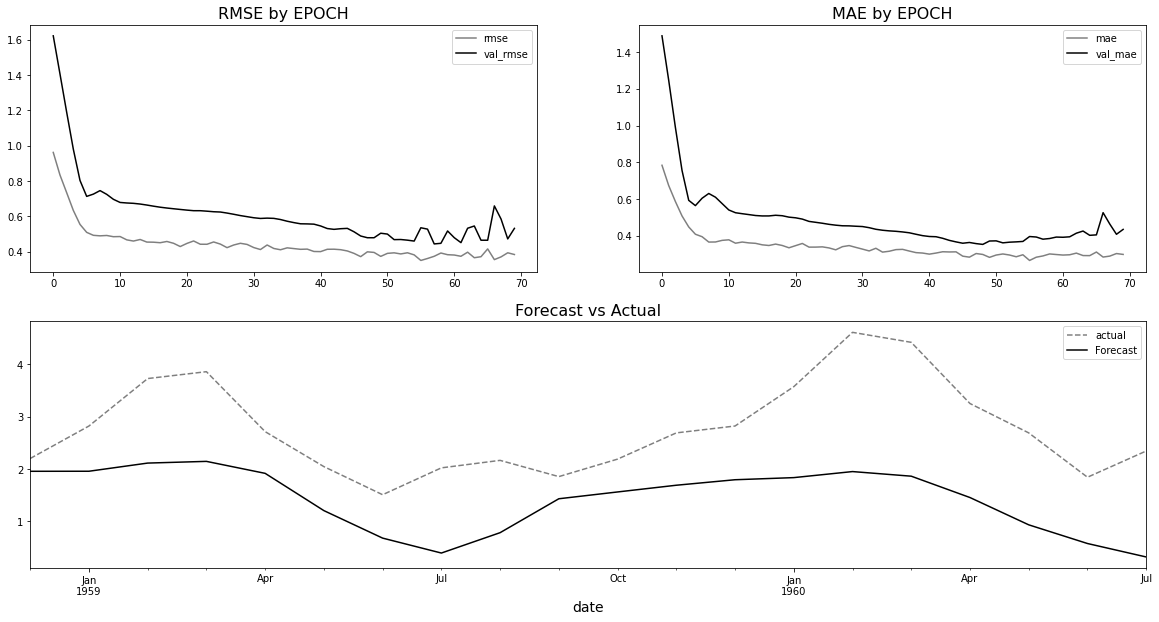

In [117]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [118]:
tf.keras.backend.clear_session()

In [119]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
33/33 [==============================] - 4s 29ms/step - loss: 0.9504 - root_mean_squared_error: 0.9749 - mean_absolute_error: 0.8055 - val_loss: 0.7301 - val_root_mean_squared_error: 0.8545 - val_mean_absolute_error: 0.6856
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.9038 - root_mean_squared_error: 0.9507 - mean_absolute_error: 0.7725 - val_loss: 0.7087 - val_root_mean_squared_error: 0.8418 - val_mean_absolute_error: 0.6667
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.8849 - root_mean_squared_error: 0.9407 - mean_absolute_error: 0.7602 - val_loss: 0.6932 - val_root_mean_squared_error: 0.8326 - val_mean_absolute_error: 0.6581
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.8658 - root_mean_squared_error: 0.9305 - mean_absolute_error: 0.7493 - val_loss: 0.6776 - val_root_mean_squared_error: 0.8231 - val_mean_absolute_error: 0.6480
Epoch 5/500
33/33 [==============================] - 0s 6ms

### Energy Consumption

In [120]:
tf.keras.backend.clear_session()

In [121]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
7/7 [==============================] - 4s 139ms/step - loss: 1.0066 - root_mean_squared_error: 1.0033 - mean_absolute_error: 0.8238 - val_loss: 1.5913 - val_root_mean_squared_error: 1.2615 - val_mean_absolute_error: 0.8806
Epoch 2/500
7/7 [==============================] - 0s 12ms/step - loss: 0.9956 - root_mean_squared_error: 0.9978 - mean_absolute_error: 0.8182 - val_loss: 1.5857 - val_root_mean_squared_error: 1.2593 - val_mean_absolute_error: 0.8789
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.9931 - root_mean_squared_error: 0.9965 - mean_absolute_error: 0.8178 - val_loss: 1.5749 - val_root_mean_squared_error: 1.2549 - val_mean_absolute_error: 0.8758
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.9915 - root_mean_squared_error: 0.9957 - mean_absolute_error: 0.8181 - val_loss: 1.5634 - val_root_mean_squared_error: 1.2504 - val_mean_absolute_error: 0.8728
Epoch 5/500
7/7 [==============================] - 0s 11ms/step

## Compare

In [122]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 288ms/step - loss: 1.7040 - root_mean_squared_error: 1.3054 - mean_absolute_error: 1.0701


,MSE,RMSE,MAE
GRU,0.590499,0.768439,0.614706
LSTM,0.767790,0.876236,0.707792
Deep LSTM,1.354970,1.164032,1.032659
SimpleRNN,1.357119,1.164955,0.968687
TimeDistributed,1.704016,1.305380,1.070051
Bidirectional,2.204298,1.484688,1.337502


In [123]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 378ms/step - loss: 3.9241 - root_mean_squared_error: 1.9809 - mean_absolute_error: 1.6749


,MSE,RMSE,MAE
LSTM,0.595962,0.771986,0.662259
GRU,1.038485,1.019061,0.850229
SimpleRNN,1.159622,1.076858,0.887238
Deep LSTM,1.162683,1.078278,0.872457
Bidirectional,1.367344,1.169335,0.957749
TimeDistributed,3.924140,1.980944,1.674944


In [124]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 18ms/step - loss: 11.1369 - root_mean_squared_error: 3.3372 - mean_absolute_error: 3.2015


,MSE,RMSE,MAE
SimpleRNN,0.522525,0.722859,0.615079
GRU,1.735824,1.317507,1.150710
Deep LSTM,2.469591,1.571493,1.455922
LSTM,2.879081,1.696786,1.589483
Bidirectional,4.103170,2.025628,1.924271
TimeDistributed,11.136941,3.337206,3.201540


## How it works

In [279]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential(
        [SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])),
         Dropout(dropout),
         Dense(1)
        ]
    )
    
    return model

In [280]:
tf.keras.backend.clear_session()
model_a_simpleRNN_1 = create_model(train=x_train_air, units=32)
model_a_simpleRNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [281]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

tf.keras.backend.clear_session()
model_a_simpleRNN = create_model(train=x_train_air, units=32)
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


## There is more

Using Keras Model API 

In [282]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import (RootMeanSquaredError, 
                                     MeanAbsoluteError)
from keras.layers import (Dense,  
                LSTM, Dropout, 
                Input, Activation)

In [283]:
def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(5,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

In [267]:
x_train_air.shape

(102, 5, 1)

In [268]:
tf.keras.backend.clear_session()

In [269]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable p

### Air Passenger

In [270]:
history_a_m = train_model(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 4s 237ms/step - loss: 0.8882 - root_mean_squared_error: 0.9425 - mean_absolute_error: 0.7646 - val_loss: 2.6985 - val_root_mean_squared_error: 1.6427 - val_mean_absolute_error: 1.5041
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 0.7838 - root_mean_squared_error: 0.8853 - mean_absolute_error: 0.7161 - val_loss: 2.3973 - val_root_mean_squared_error: 1.5483 - val_mean_absolute_error: 1.3965
Epoch 3/500
4/4 [==============================] - 0s 18ms/step - loss: 0.7248 - root_mean_squared_error: 0.8514 - mean_absolute_error: 0.6847 - val_loss: 2.0935 - val_root_mean_squared_error: 1.4469 - val_mean_absolute_error: 1.2781
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 0.6636 - root_mean_squared_error: 0.8146 - mean_absolute_error: 0.6570 - val_loss: 1.7923 - val_root_mean_squared_error: 1.3388 - val_mean_absolute_error: 1.1476
Epoch 5/500
4/4 [==============================] - 0s 18ms/step

In [271]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 30ms/step - loss: 1.5720 - root_mean_squared_error: 1.2538 - mean_absolute_error: 1.1308


[1.5719953775405884, 1.253792405128479, 1.1308104991912842]

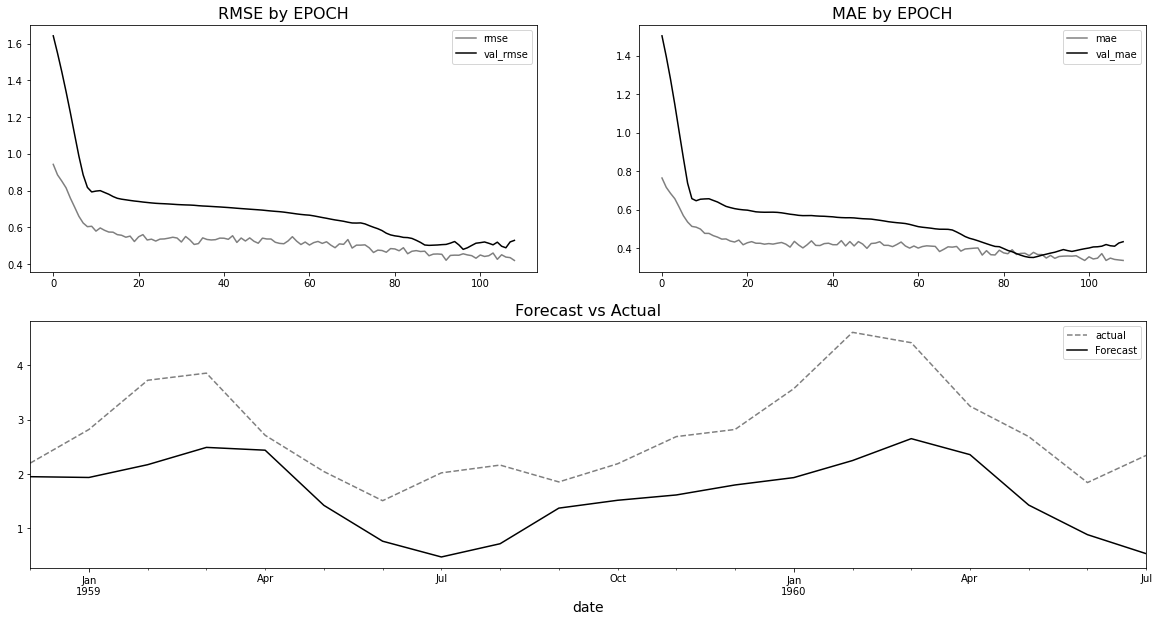

In [272]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)